In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize, LabelBinarizer
from scipy.optimize import minimize

In [2]:
# def load_data(test_size=0.2, random_state=42, stratify=True):
#     """
#     Loads the Iris dataset and splits it into training and test sets.

#     Parameters:
#     - test_size (float): Proportion of the dataset to include in the test split.
#     - random_state (int): Controls the shuffling applied to the data before applying the split.
#     - stratify (bool): Whether to stratify the split based on the target variable.

#     Returns:
#     - X_train, X_test, y_train, y_test: Split datasets.
#     """
#     X, y = load_iris(return_X_y=True)
#     X = pd.DataFrame(X, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
#     y = pd.Series(y, name='species')
#     stratify_param = y if stratify else None
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=random_state, stratify=stratify_param
#     )
#     print("Data loaded and split into training and test sets.")
#     return X_train, X_test, y_train, y_test

In [3]:
# # Load and split the data
# X_train, X_test, y_train, y_test = load_data()
# display(X_train.head())

In [4]:
def load_digits_data(test_size=0.2, random_state=42, stratify=True):
    """
    Loads the Digits dataset and splits it into training and test sets.

    Parameters:
    - test_size (float): Proportion of the dataset to include in the test split.
    - random_state (int): Controls the shuffling applied to the data before applying the split.
    - stratify (bool): Whether to stratify the split based on the target variable.

    Returns:
    - X_train, X_test, y_train, y_test: Split datasets.
    """
    digits = load_digits()
    X = pd.DataFrame(digits.data, columns=[f'pixel_{i}' for i in range(digits.data.shape[1])])
    y = pd.Series(digits.target, name='digit')

    # Determine stratification
    stratify_param = y if stratify else None

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_param
    )

    print("Digits dataset loaded and split into training and test sets.")
    return X_train, X_test, y_train, y_test

In [5]:
# Load and split the Digits dataset
X_train, X_test, y_train, y_test = load_digits_data()

# Concatenate X_train and y_train with y_train first
train_df = pd.concat([y_train, X_train], axis=1)

# Display the data
display(train_df.head())

Digits dataset loaded and split into training and test sets.


,digit,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_54,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63
421,5,0.0,0.0,11.0,10.0,12.0,14.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.0,14.0,9.0,2.0,0.0,0.0
825,0,0.0,0.0,2.0,13.0,15.0,7.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,14.0,14.0,1.0,0.0,0.0
885,5,0.0,1.0,15.0,16.0,16.0,16.0,5.0,0.0,0.0,...,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0
182,7,0.0,0.0,5.0,16.0,12.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,11.0,0.0,0.0,0.0,0.0
151,1,0.0,0.0,0.0,0.0,5.0,14.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,13.0,4.0,0.0


In [6]:
def initialize_models(random_state=42):
    """
    Initializes base classifiers.

    Parameters:
    - random_state (int): Controls the randomness of the estimators.

    Returns:
    - estimators (list of tuples): List containing (name, estimator) tuples.
    """
    clf1 = LogisticRegression(max_iter=1000, random_state=random_state)
    clf2 = DecisionTreeClassifier(random_state=random_state)
    clf3 = SVC(probability=True, random_state=random_state)
    estimators = [('lr', clf1), ('dt', clf2), ('svc', clf3)]
    print("Base classifiers initialized.")
    return estimators

In [7]:
# Initialize the models
estimators = initialize_models()

Base classifiers initialized.


In [8]:
def optimize_weights(estimators, X_train, y_train, cv=5):
    """
    Optimizes ensemble weights using SciPy's minimize function.

    Parameters:
    - estimators (list of tuples): List containing (name, estimator) tuples.
    - X_train (ndarray): Training feature matrix.
    - y_train (ndarray): Training target vector.
    - cv (int): Number of cross-validation folds.

    Returns:
    - optimized_weights (ndarray): Array of optimized weights.
    """
    def ensemble_score(weights):
        ensemble = VotingClassifier(
            estimators=estimators,
            voting='soft',
            weights=weights
        )
        scores = cross_val_score(ensemble, X_train, y_train, cv=cv, scoring='accuracy')
        return -scores.mean()

    n_estimators = len(estimators)
    initial_weights = np.array([1.0] * n_estimators)
    bounds = [(0, 1) for _ in range(n_estimators)]
    constraints = ({
        'type': 'eq',
        'fun': lambda w: 1.0 - np.sum(w)
    })

    result = minimize(
        ensemble_score,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False}
    )

    if result.success:
        optimized_weights = result.x
        print(f"Optimized Weights: {optimized_weights}")
    else:
        raise ValueError(f"Optimization failed: {result.message}")

    return optimized_weights

In [9]:
# Optimize the weights
optimized_weights = optimize_weights(estimators, X_train, y_train)

Optimized Weights: [0.33333333 0.33333333 0.33333333]


In [10]:
def train_classifiers(estimators, X_train, y_train):
    """
    Trains individual classifiers.

    Parameters:
    - estimators (list of tuples): List containing (name, estimator) tuples.
    - X_train (ndarray): Training feature matrix.
    - y_train (ndarray): Training target vector.

    Returns:
    - trained_estimators (dict): Dictionary of trained classifiers.
    """
    trained_estimators = {}
    for name, clf in estimators:
        clf.fit(X_train, y_train)
        trained_estimators[name] = clf
        print(f"Trained {name}.")
    return trained_estimators

In [11]:
# Train individual classifiers
trained_estimators = train_classifiers(estimators, X_train, y_train)

Trained lr.
Trained dt.
Trained svc.


In [12]:
def train_ensemble(estimators, weights, X_train, y_train):
    """
    Trains the weighted ensemble classifier.

    Parameters:
    - estimators (list of tuples): List containing (name, estimator) tuples.
    - weights (ndarray): Array of weights for the ensemble.
    - X_train (ndarray): Training feature matrix.
    - y_train (ndarray): Training target vector.

    Returns:
    - ensemble (VotingClassifier): Trained ensemble classifier.
    """
    ensemble = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=weights
    )
    ensemble.fit(X_train, y_train)
    print("Trained weighted ensemble with optimized weights.")
    return ensemble

In [13]:
 # Train the ensemble
ensemble = train_ensemble(estimators, optimized_weights, X_train, y_train)

Trained weighted ensemble with optimized weights.


In [14]:
def evaluate_classifiers(classifiers, X_test, y_test):
    """
    Evaluates classifiers using Accuracy, F1-Score, and ROC-AUC.

    Parameters:
    - classifiers (dict): Dictionary of classifiers with names as keys.
    - X_test (ndarray): Test set feature matrix.
    - y_test (ndarray): Test set target vector.

    Returns:
    - results_df (DataFrame): DataFrame containing evaluation metrics.
    """
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
    results = {}

    for name, clf in classifiers.items():
        y_pred = clf.predict(X_test)

        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)
        else:
            # Handle classifiers without predict_proba
            lb = LabelBinarizer()
            lb.fit(y_test)
            y_proba = lb.transform(clf.decision_function(X_test))

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        roc_auc = roc_auc_score(y_test_binarized, y_proba, average='macro', multi_class='ovr')

        results[name] = {
            'Accuracy': acc,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
        print(f"Evaluated {name}: Accuracy={acc:.4f}, F1-Score={f1:.4f}, ROC-AUC={roc_auc:.4f}")

    results_df = pd.DataFrame(results).T
    return results_df

In [15]:
# Prepare classifiers for evaluation
classifiers = {
    'Logistic Regression': trained_estimators['lr'],
    'Decision Tree': trained_estimators['dt'],
    'SVC': trained_estimators['svc'],
    'Weighted Ensemble': ensemble
}

# Evaluate the classifiers
results_df = evaluate_classifiers(classifiers, X_test, y_test)
print("\nClassification Metrics Comparison:")
display(results_df)

Evaluated Logistic Regression: Accuracy=0.9583, F1-Score=0.9581, ROC-AUC=0.9989
Evaluated Decision Tree: Accuracy=0.8250, F1-Score=0.8230, ROC-AUC=0.9024
Evaluated SVC: Accuracy=0.9917, F1-Score=0.9916, ROC-AUC=0.9999
Evaluated Weighted Ensemble: Accuracy=0.9722, F1-Score=0.9719, ROC-AUC=0.9990

Classification Metrics Comparison:


,Accuracy,F1-Score,ROC-AUC
Logistic Regression,0.958333,0.958075,0.998932
Decision Tree,0.825000,0.823049,0.902404
SVC,0.991667,0.991578,0.999931
Weighted Ensemble,0.972222,0.971875,0.999020


In [16]:
def visualize_results(results_df):
    """
    Creates a grouped bar plot to compare classification metrics.

    Parameters:
    - results_df (DataFrame): DataFrame containing evaluation metrics.
    """
    # Reshape the DataFrame for seaborn
    results_plot = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
    results_plot.rename(columns={'index': 'Classifier'}, inplace=True)

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 5))

    # Create the grouped bar plot
    ax = sns.barplot(
        data=results_plot,
        x='Metric',
        y='Score',
        hue='Classifier'
    )

    # Add title and labels
    plt.title('Comparison of Classification Metrics', fontsize=16)
    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Metric', fontsize=14)
    plt.ylim(0, 1.07)

    # Move the legend outside the plot
    plt.legend(
        title='Classifier',
        bbox_to_anchor=(1.03, 1),
        loc='upper left',
        borderaxespad=0.,
        fontsize=8,
        title_fontsize=10,
        handlelength=1.5,
        handletextpad=0.5
    )

    # Annotate each bar with its height value
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.2f}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()

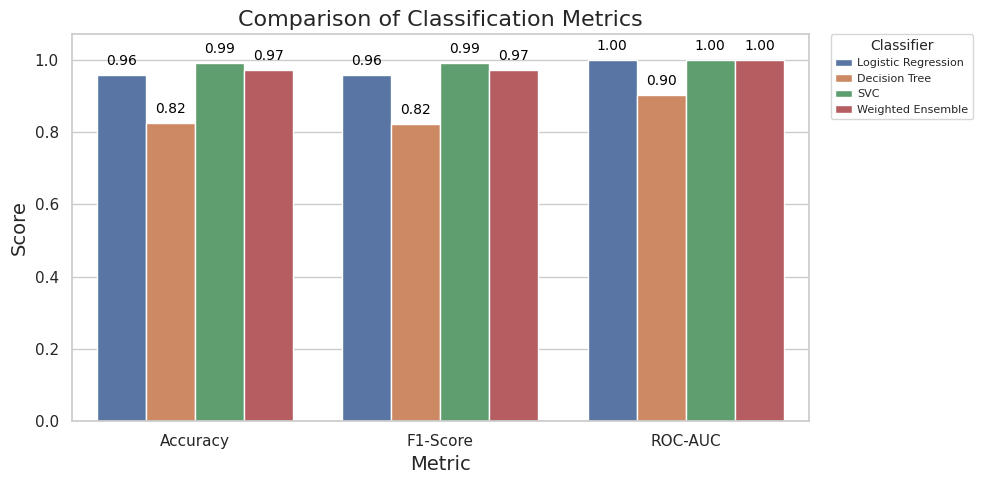

In [17]:
# Visualize the results
visualize_results(results_df)

In [18]:
!pip install -q optuna

In [19]:
import optuna

def objective(trial, X_train, y_train, estimators):
    # Suggest hyperparameters for each estimator
    lr_C = trial.suggest_float('lr__C', 0.01, 100, log=True)
    dt_max_depth = trial.suggest_int('dt__max_depth', 1, 20)
    dt_min_samples_split = trial.suggest_int('dt__min_samples_split', 2, 10)
    svc_C = trial.suggest_float('svc__C', 0.01, 100, log=True)
    svc_gamma = trial.suggest_categorical('svc__gamma', ['scale', 'auto'])
    svc_kernel = trial.suggest_categorical('svc__kernel', ['rbf', 'linear'])

    # Suggest ensemble weights
    weight_lr = trial.suggest_float('weight_lr', 0.0, 5.0)
    weight_dt = trial.suggest_float('weight_dt', 0.0, 5.0)
    weight_svc = trial.suggest_float('weight_svc', 0.0, 5.0)

    # Normalize weights to sum to 1
    total = weight_lr + weight_dt + weight_svc
    weights = [weight_lr / total, weight_dt / total, weight_svc / total]

    # Set hyperparameters
    estimators_tuned = [
        ('lr', LogisticRegression(C=lr_C, penalty='l2', max_iter=1000, random_state=42)),
        ('dt', DecisionTreeClassifier(max_depth=dt_max_depth, min_samples_split=dt_min_samples_split, random_state=42)),
        ('svc', SVC(C=svc_C, gamma=svc_gamma, kernel=svc_kernel, probability=True, random_state=42))
    ]

    # Define VotingClassifier
    voting_clf = VotingClassifier(
        estimators=estimators_tuned,
        voting='soft',
        weights=weights,
        n_jobs=-1
    )

    # Perform cross-validation
    scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean()

In [20]:
def optimize_with_optuna(X_train, y_train, estimators, n_trials=100):
    """
    Optimizes both hyperparameters of individual models and ensemble weights using Optuna.

    Parameters:
    - X_train (ndarray): Training feature matrix.
    - y_train (ndarray): Training target vector.
    - estimators (list of tuples): List containing (name, estimator) tuples.
    - n_trials (int): Number of trials for optimization.

    Returns:
    - best_estimator (VotingClassifier): The best VotingClassifier found.
    - best_params (dict): Best parameters found by Optuna.
    - best_score (float): Best cross-validated score.
    """
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, estimators), n_trials=n_trials)

    print(f"Best Score: {study.best_value:.4f}")
    print(f"Best Parameters: {study.best_params}")

    # Extract the best hyperparameters and weights
    best_params = study.best_params

    # Normalize weights
    weights = [
        best_params['weight_lr'],
        best_params['weight_dt'],
        best_params['weight_svc']
    ]
    total = sum(weights)
    weights = [w / total for w in weights]

    # Initialize the best ensemble
    best_ensemble = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(C=best_params['lr__C'], penalty='l2', max_iter=1000, random_state=42)),
            ('dt', DecisionTreeClassifier(max_depth=best_params['dt__max_depth'], min_samples_split=best_params['dt__min_samples_split'], random_state=42)),
            ('svc', SVC(C=best_params['svc__C'], gamma=best_params['svc__gamma'], kernel=best_params['svc__kernel'], probability=True, random_state=42))
        ],
        voting='soft',
        weights=weights,
        n_jobs=-1
    )

    # Fit the best ensemble on the entire training data
    best_ensemble.fit(X_train, y_train)

    return best_ensemble, best_params, study.best_value

In [21]:
# Optimize with Optuna
best_ensemble, best_params, best_score = optimize_with_optuna(X_train, y_train, estimators, n_trials=100)

[I 2025-01-20 16:40:13,965] A new study created in memory with name: no-name-29bf3385-2b64-4a08-aafb-69a39a3e15f4
[I 2025-01-20 16:40:17,433] Trial 0 finished with value: 0.8830720092915214 and parameters: {'lr__C': 48.04921202021866, 'dt__max_depth': 9, 'dt__min_samples_split': 7, 'svc__C': 14.671203097505023, 'svc__gamma': 'auto', 'svc__kernel': 'linear', 'weight_lr': 0.1763228643537751, 'weight_dt': 3.9946086571924138, 'weight_svc': 2.6483802015809377}. Best is trial 0 with value: 0.8830720092915214.
[I 2025-01-20 16:40:21,521] Trial 1 finished with value: 0.9603222996515679 and parameters: {'lr__C': 3.092409576464099, 'dt__max_depth': 8, 'dt__min_samples_split': 5, 'svc__C': 0.5614866162437181, 'svc__gamma': 'auto', 'svc__kernel': 'rbf', 'weight_lr': 2.937048580048395, 'weight_dt': 2.3127629207214406, 'weight_svc': 2.9155842881491933}. Best is trial 1 with value: 0.9603222996515679.
[I 2025-01-20 16:40:24,056] Trial 2 finished with value: 0.8482941347270616 and parameters: {'lr__C'

Best Score: 0.9882
Best Parameters: {'lr__C': 50.956876726339104, 'dt__max_depth': 1, 'dt__min_samples_split': 8, 'svc__C': 8.329435730775266, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'weight_lr': 0.10023306623938244, 'weight_dt': 0.9590609680151563, 'weight_svc': 2.3039800471145866}


In [22]:
def objective_lr(trial, X_train, y_train):
    """
    Objective function for tuning Logistic Regression.
    """
    lr_C = trial.suggest_float('C', 0.01, 100, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2'])
    solver = 'lbfgs' if penalty == 'l2' else 'liblinear'
    clf = LogisticRegression(C=lr_C, penalty=penalty, solver=solver, max_iter=1000, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return score

def objective_dt(trial, X_train, y_train):
    """
    Objective function for tuning Decision Tree.
    """
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return score

def objective_svc(trial, X_train, y_train):
    """
    Objective function for tuning SVC.
    """
    svc_C = trial.suggest_float('C', 0.01, 100, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    svc_kernel = trial.suggest_categorical('kernel', ['rbf', 'linear'])
    clf = SVC(C=svc_C, gamma=svc_gamma, kernel=svc_kernel, probability=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return score

In [23]:
def tune_individual_model(objective_func, model_name, X_train, y_train, n_trials=100):
    """
    Tunes hyperparameters for a single classifier using Optuna.

    Parameters:
    - objective_func (function): The objective function for Optuna.
    - model_name (str): Name of the classifier.
    - X_train (DataFrame): Training features.
    - y_train (Series): Training labels.
    - n_trials (int): Number of Optuna trials.

    Returns:
    - best_params (dict): Best hyperparameters found.
    """
    study = optuna.create_study(direction='maximize', study_name=f'Tune_{model_name}')
    study.optimize(lambda trial: objective_func(trial, X_train, y_train), n_trials=n_trials)

    print(f"Best score for {model_name}: {study.best_value:.4f}")
    print(f"Best parameters for {model_name}: {study.best_params}")
    print("\n")

    return study.best_params

In [24]:
# Tune Logistic Regression
best_params_lr = tune_individual_model(objective_lr, 'LogisticRegression', X_train, y_train, n_trials=100)

# Tune Decision Tree
best_params_dt = tune_individual_model(objective_dt, 'DecisionTree', X_train, y_train, n_trials=100)

# Tune SVC
best_params_svc = tune_individual_model(objective_svc, 'SVC', X_train, y_train, n_trials=100)

[I 2025-01-20 16:44:34,121] A new study created in memory with name: Tune_LogisticRegression
[I 2025-01-20 16:44:34,550] Trial 0 finished with value: 0.9547619047619047 and parameters: {'C': 15.253846708155889, 'penalty': 'l2'}. Best is trial 0 with value: 0.9547619047619047.
[I 2025-01-20 16:44:35,390] Trial 1 finished with value: 0.9610312620983352 and parameters: {'C': 1.3123021224323916, 'penalty': 'l2'}. Best is trial 1 with value: 0.9610312620983352.
[I 2025-01-20 16:44:38,560] Trial 2 finished with value: 0.9652027680991095 and parameters: {'C': 0.21682246197385702, 'penalty': 'l2'}. Best is trial 2 with value: 0.9652027680991095.
[I 2025-01-20 16:44:40,194] Trial 3 finished with value: 0.9568476577622919 and parameters: {'C': 10.06136516486473, 'penalty': 'l2'}. Best is trial 2 with value: 0.9652027680991095.
[I 2025-01-20 16:44:42,034] Trial 4 finished with value: 0.9596351142082848 and parameters: {'C': 8.158268779264205, 'penalty': 'l2'}. Best is trial 2 with value: 0.965202

Best score for LogisticRegression: 0.9694
Best parameters for LogisticRegression: {'C': 0.08279021334313658, 'penalty': 'l2'}




[I 2025-01-20 16:47:54,424] Trial 1 finished with value: 0.8134872241579558 and parameters: {'max_depth': 7, 'min_samples_split': 7}. Best is trial 1 with value: 0.8134872241579558.
[I 2025-01-20 16:47:54,569] Trial 2 finished with value: 0.6736377274487031 and parameters: {'max_depth': 5, 'min_samples_split': 8}. Best is trial 1 with value: 0.8134872241579558.
[I 2025-01-20 16:47:54,686] Trial 3 finished with value: 0.3180144212156407 and parameters: {'max_depth': 2, 'min_samples_split': 5}. Best is trial 1 with value: 0.8134872241579558.
[I 2025-01-20 16:47:54,779] Trial 4 finished with value: 0.19833042973286877 and parameters: {'max_depth': 1, 'min_samples_split': 9}. Best is trial 1 with value: 0.8134872241579558.
[I 2025-01-20 16:47:54,935] Trial 5 finished with value: 0.8433967286101431 and parameters: {'max_depth': 15, 'min_samples_split': 3}. Best is trial 5 with value: 0.8433967286101431.
[I 2025-01-20 16:47:55,054] Trial 6 finished with value: 0.8482602593883082 and paramete

Best score for DecisionTree: 0.8497
Best parameters for DecisionTree: {'max_depth': 20, 'min_samples_split': 2}




[I 2025-01-20 16:48:12,247] Trial 0 finished with value: 0.7084010840108401 and parameters: {'C': 0.02412825212061987, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 0 with value: 0.7084010840108401.
[I 2025-01-20 16:48:12,816] Trial 1 finished with value: 0.9735506194347657 and parameters: {'C': 0.37424974228383584, 'gamma': 'scale', 'kernel': 'linear'}. Best is trial 1 with value: 0.9735506194347657.
[I 2025-01-20 16:48:13,373] Trial 2 finished with value: 0.9735506194347657 and parameters: {'C': 6.805520071175869, 'gamma': 'scale', 'kernel': 'linear'}. Best is trial 1 with value: 0.9735506194347657.
[I 2025-01-20 16:48:13,934] Trial 3 finished with value: 0.9735506194347657 and parameters: {'C': 0.6665522795365709, 'gamma': 'scale', 'kernel': 'linear'}. Best is trial 1 with value: 0.9735506194347657.
[I 2025-01-20 16:48:17,437] Trial 4 finished with value: 0.10647986837011228 and parameters: {'C': 0.29175545875793246, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 1 with value:

Best score for SVC: 0.9903
Best parameters for SVC: {'C': 3.2186220249260447, 'gamma': 'scale', 'kernel': 'rbf'}




In [25]:
def train_tuned_individual_models(best_params_lr, best_params_dt, best_params_svc, X_train, y_train):
    """
    Trains individually tuned classifiers.

    Parameters:
    - best_params_lr (dict): Best hyperparameters for Logistic Regression.
    - best_params_dt (dict): Best hyperparameters for Decision Tree.
    - best_params_svc (dict): Best hyperparameters for SVC.
    - X_train (DataFrame): Training features.
    - y_train (Series): Training labels.

    Returns:
    - tuned_classifiers (dict): Dictionary of trained tuned classifiers.
    """
    # Initialize classifiers with best parameters
    clf_lr = LogisticRegression(
        C=best_params_lr['C'],
        penalty=best_params_lr['penalty'],
        solver='lbfgs' if best_params_lr['penalty'] == 'l2' else 'liblinear',
        max_iter=1000,
        random_state=42
    )

    clf_dt = DecisionTreeClassifier(
        max_depth=best_params_dt['max_depth'],
        min_samples_split=best_params_dt['min_samples_split'],
        random_state=42
    )

    clf_svc = SVC(
        C=best_params_svc['C'],
        gamma=best_params_svc['gamma'],
        kernel=best_params_svc['kernel'],
        probability=True,
        random_state=42
    )

    # Train classifiers
    clf_lr.fit(X_train, y_train)
    clf_dt.fit(X_train, y_train)
    clf_svc.fit(X_train, y_train)

    tuned_classifiers = {
        'Tuned Logistic Regression': clf_lr,
        'Tuned Decision Tree': clf_dt,
        'Tuned SVC': clf_svc
    }

    print("Trained individually tuned classifiers.")
    return tuned_classifiers

In [26]:
# Train tuned individual classifiers
tuned_classifiers = train_tuned_individual_models(best_params_lr, best_params_dt, best_params_svc, X_train, y_train)

Trained individually tuned classifiers.


In [27]:
# Prepare classifiers for evaluation
classifiers_tuned = {
    'Tuned Logistic Regression': tuned_classifiers['Tuned Logistic Regression'],
    'Tuned Decision Tree': tuned_classifiers['Tuned Decision Tree'],
    'Tuned SVC': tuned_classifiers['Tuned SVC'],
    'Tuned Ensemble': best_ensemble
}

# Evaluate the classifiers
results_df_tuned = evaluate_classifiers(classifiers_tuned, X_test, y_test)
print("\nClassification Metrics Comparison (Tuned Models):")
display(results_df_tuned)

Evaluated Tuned Logistic Regression: Accuracy=0.9611, F1-Score=0.9609, ROC-AUC=0.9991
Evaluated Tuned Decision Tree: Accuracy=0.8250, F1-Score=0.8230, ROC-AUC=0.9024
Evaluated Tuned SVC: Accuracy=0.9944, F1-Score=0.9944, ROC-AUC=1.0000
Evaluated Tuned Ensemble: Accuracy=0.9889, F1-Score=0.9888, ROC-AUC=1.0000

Classification Metrics Comparison (Tuned Models):


,Accuracy,F1-Score,ROC-AUC
Tuned Logistic Regression,0.961111,0.960933,0.999140
Tuned Decision Tree,0.825000,0.823049,0.902404
Tuned SVC,0.994444,0.994403,0.999965
Tuned Ensemble,0.988889,0.988810,0.999957


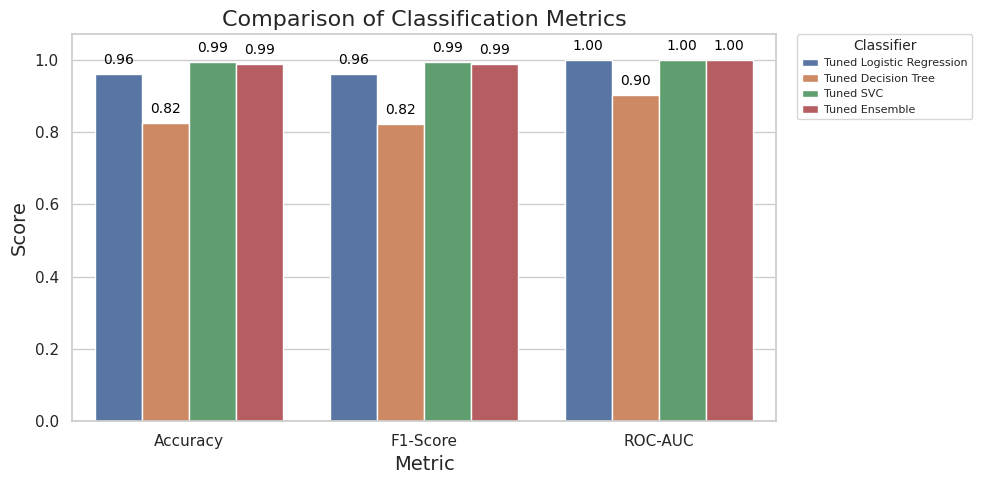

In [28]:
# Visualize the results
visualize_results(results_df_tuned)